# installation


In [1]:
#install required packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git



     |████████████████████████████████| 7.9 MB 30.6 MB/s 
     |████████████████████████████████| 3.5 MB 39.1 MB/s 


In [2]:
# helper function for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize = (10, 10))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s = 70, c = color, cmap = 'Set2')
  plt.show()

# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root = "data/Planetoid", name = "Cora", transform = NormalizeFeatures())
print(dataset)

print("---"*36)
print(f'length of the dataset: {len(dataset)}')
print(f'features in the dataset: {dataset.num_features}')
print(f'Number of classes in the dataset: {dataset.num_classes}')
print("---"*36)
data = dataset[0]
print('print dataset properties')
print(data)

print(f'Number of nodes in the dataset: {data.num_nodes}')
print(f'Number of edges in the dataset: {data.num_edges}')
print(f'Average Node degree: {data.num_edges/data.num_nodes:0.2f}')
print(f'number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {data.train_mask.sum()/data.num_nodes:0.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...


Cora()
------------------------------------------------------------------------------------------------------------
length of the dataset: 1
features in the dataset: 1433
Number of classes in the dataset: 7
------------------------------------------------------------------------------------------------------------
print dataset properties
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes in the dataset: 2708
Number of edges in the dataset: 10556
Average Node degree: 3.90
number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self, hidden_channles):
    super().__init__()
    torch.manual_seed(12345)
    self.l1 = Linear(dataset.num_features, hidden_channles)
    self.l2 = Linear(hidden_channles, dataset.num_classes)

  def forward(self, x):
    x = self.l1(x)
    x = F.relu(x)
    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.l2(x)
    return x


model = MLP(hidden_channles=16)
print(model)


MLP(
  (l1): Linear(in_features=1433, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=7, bias=True)
)


In [5]:

model = MLP(hidden_channles=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)



In [6]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x)
  pred = out.argmax(dim=1)
  test_correct = (pred[data.test_mask] == data.y[data.test_mask])
  test_acc = int(test_correct.sum())/int(data.test_mask.sum())
  return test_acc
for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [7]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [15]:
from torch_geometric.nn import GCNConv 
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.conv2(x, edge_index)
    return x
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


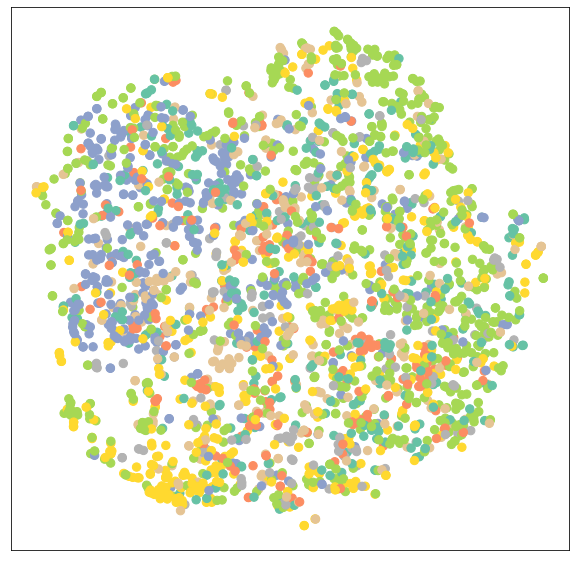

In [13]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color = data.y)

In [27]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


model = GCN(hidden_channels = 16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  corrects = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(corrects.sum())/int(data.test_mask.sum())
  return test_acc

for epoch in range(1, 101):
    loss = train()
    if epoch %10 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 010, Loss: 1.8726
Epoch: 020, Loss: 1.7503
Epoch: 030, Loss: 1.5775
Epoch: 040, Loss: 1.4028
Epoch: 050, Loss: 1.1911
Epoch: 060, Loss: 1.0361
Epoch: 070, Loss: 0.8618
Epoch: 080, Loss: 0.7470
Epoch: 090, Loss: 0.6732
Epoch: 100, Loss: 0.6336


In [28]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8080


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


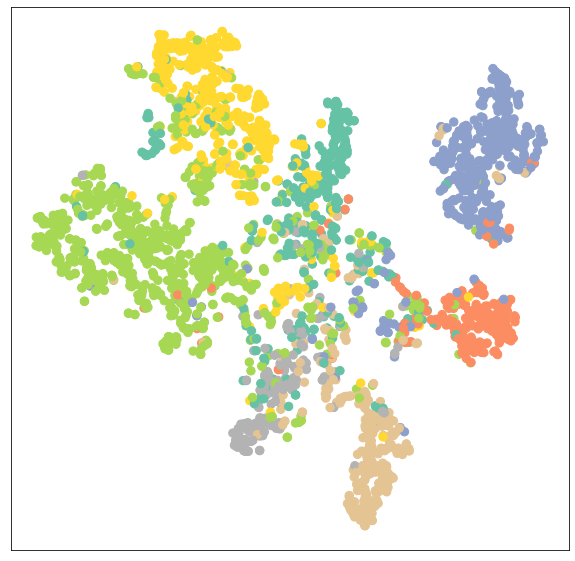

In [29]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)